In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import multi_dot

In [2]:
sz  = np.array([[1,0],[0,-1]])
sx  = np.array([[0,1],[1,0]])
sy  = np.array([[0,-1j],[1j,0]])
id2 = np.array([[1,0],[0,1]])

sp = np.array([[0,1],[0,0]])
sm = np.array([[0,0],[1,0]])

Let's start with bit flip and phase flip channels:

In [3]:
def btFlip(x,p):
    res = (1-p)*x+p*multi_dot([sx,x,sx])
    return res

def phFlip(x,p):
    res = (1-p)*x+p*multi_dot([sz,x,sz])
    return res

In [4]:
init_bt = np.array([[0,0],[0,1]])
proj    = np.array([[0,0],[0,1]])


nsteps = 20
prob   = np.zeros(nsteps+1)
prob[0]=np.trace(init_bt.dot(proj))

dm_temp = init_bt.copy()
dm_cur  = np.zeros_like(init_bt)

for step in range(1, prob.shape[0]):
    dm_cur     = btFlip(dm_temp, 0.1)
    dm_temp    = dm_cur.copy()
    prob[step] = np.trace(dm_cur.dot(proj))

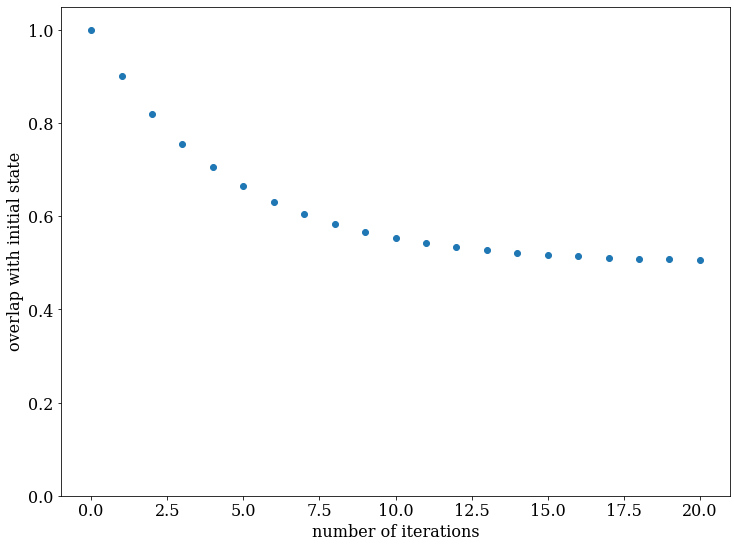

In [5]:
import matplotlib
%matplotlib inline
matplotlib.rcParams.update({'font.size': 16,'font.family':'serif'})
fig, ax = plt.subplots(figsize=(12, 9))

trange = np.arange(nsteps+1)
plt.scatter(trange,prob, label = r'$\rho_{11}$')

plt.xlabel('number of iterations')
plt.ylabel('overlap with initial state')

plt.ylim(0, 1.05)
#plt.legend(loc = "best",numpoints=1,frameon=True)

plt.show()

In [6]:
import matplotlib as mpl
from pylab import *
from qutip import *
from matplotlib import cm
import imageio

In [7]:
def BlochVec(x):
    X = np.real(np.trace(sx.dot(x)))
    Y = np.real(np.trace(sy.dot(x)))
    Z = np.real(np.trace(sz.dot(x)))
    return np.array([X,Y,Z])

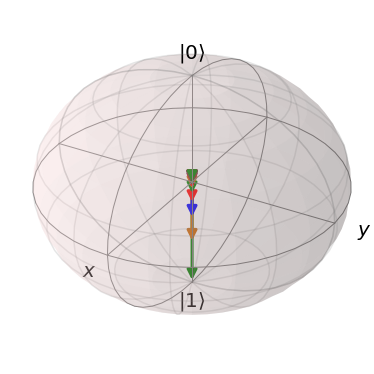

In [8]:
init_bt = np.array([[0,0],[0,1]])

nsteps = 5
bVec = []
bVec.append(BlochVec(init_bt))

dm_temp = init_bt.copy()
dm_cur  = np.zeros_like(init_bt)

for step in range(1, prob.shape[0]):
    dm_cur     = btFlip(dm_temp, 0.2)
    dm_temp    = dm_cur.copy()
    bVec.append(BlochVec(dm_cur))

b = Bloch()
b.add_vectors(bVec)
b.show()

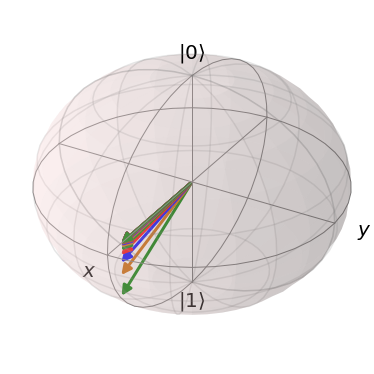

In [9]:
iVec = np.array([0.5,np.sqrt(3)/2])
init_bt = np.outer(iVec,iVec.T)

nsteps = 5
bVec = []
bVec.append(BlochVec(init_bt))

dm_temp = init_bt.copy()
dm_cur  = np.zeros_like(init_bt)

for step in range(1, prob.shape[0]):
    dm_cur     = btFlip(dm_temp, 0.2)
    dm_temp    = dm_cur.copy()
    bVec.append(BlochVec(dm_cur))

b = Bloch()
b.add_vectors(bVec)
b.show()

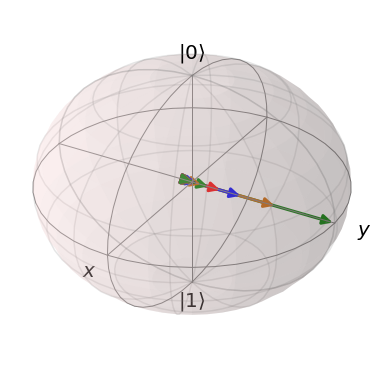

In [10]:
iVec = np.array([1/np.sqrt(2),1j/np.sqrt(2)])
init_bt = np.outer(iVec,np.conj(iVec.T))

nsteps = 5
bVec = []
bVec.append(BlochVec(init_bt))

dm_temp = init_bt.copy()
dm_cur  = np.zeros_like(init_bt)

for step in range(1, prob.shape[0]):
    dm_cur     = btFlip(dm_temp, 0.2)
    dm_temp    = dm_cur.copy()
    bVec.append(BlochVec(dm_cur))

b = Bloch()
b.add_vectors(bVec)
b.show()

Problem 1: Do similar explorations with phase flip channel & amplitude damping

Let's use the vectorization method to solve QME:

Quantum Master equation for a two-level atom in a thermal reservoir:
$$\frac{d \rho}{dt}=\mathcal{L}\rho,$$
where
$$\mathcal{L}\rho =-\imath[H_s,\rho]+\gamma(\langle n \rangle +1)\left(\sigma_-\rho\sigma_++\frac{1}{2}\left\{\sigma_+\sigma_-,\rho\right\}\right)+\gamma\langle n \rangle\left(\sigma_+\rho\sigma_-+\frac{1}{2}\left\{\sigma_-\sigma_+,\rho\right\}\right)$$
and
$$
H_s = \frac{\omega_0}{2}\sigma_z
$$

The corresponding $\hat{\mathcal{L}}$ reads:

$$
\hat{\mathcal{L}} = -i\frac{\omega_0}{2}\left(I\otimes\sigma_z-\sigma_z\otimes I\right)+\gamma(\langle n \rangle +1)\left(\sigma_-\otimes\sigma_--\frac{1}{2}I\otimes\sigma_+\sigma_--\frac{1}{2}\sigma_+\sigma_-\otimes I\right)+\gamma\langle n \rangle \left(\sigma_+\otimes\sigma_+-\frac{1}{2}I\otimes\sigma_-\sigma_+-\frac{1}{2}\sigma_-\sigma_+\otimes I\right)
$$

In [11]:
def M(omega0=10, nth=2, gamma = 0.1):
    res  = -1j*(omega0/2)*(np.kron(id2,sz)-np.kron(sz,id2))
    res += gamma*(nth+1)*(np.kron(sm,sm)-np.kron(id2,np.dot(sp,sm))/2-np.kron(np.dot(sp,sm),id2)/2)
    res += gamma*nth*(np.kron(sp,sp)-np.kron(id2,np.dot(sm,sp))/2-np.kron(np.dot(sm,sp),id2)/2)    
    return res

$$\frac{dy}{dt} = f(t, y), \quad y(t_0) = y_0$$
Runge-Kutta methods 4th order step (from wiki - https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods):
$$y_{n+1} = y_n + \frac{1}{6}h\left(k_1 + 2k_2 + 2k_3 + k_4 \right),$$
$$t_{n+1} = t_n +h,$$
where:
$$k_1 =  f(t_n, y_n),$$
$$k_2 =  f\left(t_n + \frac{h}{2}, y_n + h\frac{k_1}{2}\right),$$
$$k_3 =  f\left(t_n + \frac{h}{2}, y_n + h\frac{k_2}{2}\right),$$
$$k_4 =  f\left(t_n + h, y_n + hk_3\right).$$

In [12]:
def RK4step(x, h):
    k1 = M().dot(x)
    k2 = M().dot(x+h*k1/2)
    k3 = M().dot(x+h*k2/2)
    k4 = M().dot(x+h*k3)
    return x+(h/6)*(k1+2*k2+2*k3+k4)

The initial condition:
$$\rho(0)=|+\rangle\langle +|,$$
where 
$$|+\rangle=\frac{1}{\sqrt{2}}\left(\begin{matrix}
1\\
1
\end{matrix}\right)$$

In [13]:
init = np.array([0.5,0.5,0.5,0.5], dtype=complex)

t_i = 0
t_f = 20
nsteps = 500

h = (t_f-t_i)/nsteps

solRK = np.zeros((nsteps+1,4),dtype=complex)
solRK[0]=init

for step in range(1,solRK.shape[0]):
    solRK[step] = RK4step(solRK[step-1],h)

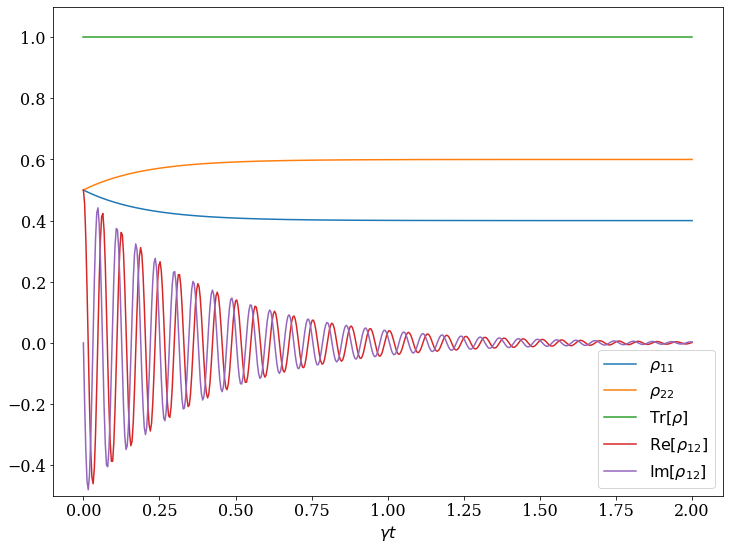

In [14]:
import matplotlib
%matplotlib inline
matplotlib.rcParams.update({'font.size': 16,'font.family':'serif'})
fig, ax = plt.subplots(figsize=(12, 9))

trange = 0.1*np.linspace(t_i,t_f,nsteps+1)
plt.plot(trange,np.real(solRK[:,0]), label = r'$\rho_{11}$')
plt.plot(trange,np.real(solRK[:,3]), label = r'$\rho_{22}$')
plt.plot(trange,np.real(solRK[:,0]+solRK[:,3]), label = r'$\mathrm{Tr}[\rho]$')
plt.plot(trange,np.real(solRK[:,2]), label = r'$\mathrm{Re}[\rho_{12}]$')
plt.plot(trange,np.imag(solRK[:,2]), label = r'$\mathrm{Im}[\rho_{12}]$')

plt.xlabel('$\gamma t$')
plt.ylim(-0.5, 1.1)
plt.legend(loc = "best",numpoints=1,frameon=True)

plt.show()

In [15]:
xvec = np.array([0,1,1,0])
yvec = np.array([0,-1j,1j,0])
zvec = np.array([1,0,0,-1])

obsRK = np.zeros((solRK.shape[0],3),dtype=float)

for x in range(obsRK.shape[0]):
    obsRK[x] = np.array([np.real(xvec.dot(solRK[x])),np.real(yvec.dot(solRK[x])),np.real(zvec.dot(solRK[x]))])

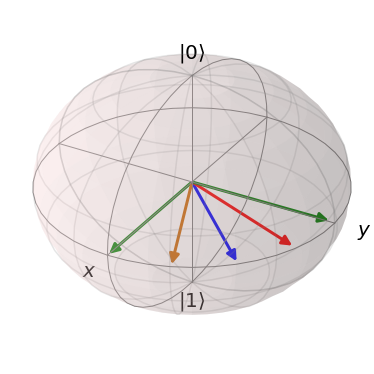

In [16]:
b = Bloch()
b.add_vectors(obsRK[:5])
b.show()

In [17]:
# taken from - https://sites.google.com/site/tanayroysite/articles/bloch-sphere-animation-using-qutip
def animate_bloch(states, duration=0.1, save_all=False):
    b = Bloch()
    b.vector_color = ['r']
    b.view = [-40,30]
    images=[]
    try:
        length = len(states)
    except:
        length = 1
        states = [states]

    ## normalize colors to the length of data ##
    nrm = mpl.colors.Normalize(0,length)
    colors = cm.cool(nrm(range(length))) # options: cool, summer, winter, autumn etc.

    ## customize sphere properties ##
    b.point_color = list(colors) # options: 'r', 'g', 'b' etc.
    b.point_marker = ['o']
    b.point_size = [30]
    

    for i in range(length):

        b.clear()
        #b.add_states(states[i])
        #b.add_states(states[:(i+1)],'point')
        b.add_vectors(states[i])
        if save_all:
            b.save(dirc='tmp') #saving images to tmp directory
            filename="tmp/bloch_%01d.png" % i
        else:
            filename='temp_file.png'
            b.save(filename)
        images.append(imageio.imread(filename))
    imageio.mimsave('bloch_anim.gif', images, duration=duration)

In [18]:
animate_bloch(obsRK[:250], duration=0.1, save_all=False)

Problem 2:
Consider a Quantum Master equation for a weakly driven two-level atom in a zero temperature reservoir:
$$\frac{d \rho}{dt}=\mathcal{L}\rho,$$
where
$$\mathcal{L}\rho =-\imath[H_s,\rho]+\gamma\left(\sigma_-\rho\sigma_++\frac{1}{2}\left\{\sigma_+\sigma_-,\rho\right\}\right)$$
and
$$
H_s = \frac{\Delta}{2}\sigma_z+ \Omega \sigma_x,
$$
where $\Delta = \omega_0-\omega_D$ and $\Omega$ is the amplitude of the driving field.